# Inports

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd

from absl import app
from absl import flags
import os 
from os.path import join
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from utils import *
# from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

/Users/gadmohamed/miniforge3/envs/fl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions



In [45]:



class Exp : 

    def __init__(self, exp_path) :
        self.exp_path = exp_path
        self.args = load_json_field(join(exp_path, 'args.json'))
        self.corrupt = False 
        self.load_history()
    
    def load_history(self) :
        if self.args['learning_algorithm'] == 'central' : 
            if not os.path.exists(join(self.exp_path, 'centralized.csv')) :
                self.corrupt = True 
                return
            history = pd.read_csv(join(self.exp_path, 'centralized.csv'))
            self.acc = history['val_accuracy']
            self.loss = history['val_loss']
        elif self.args['learning_algorithm'].startswith('fed') : 
            if not os.path.exists(join(self.exp_path, 'accuracy.npy')) :
                self.corrupt = True 
                return
            
            self.acc = np.load(join(self.exp_path, 'accuracy.npy'))
            self.loss = np.load(join(self.exp_path, 'loss.npy'))

    
    def plot(self, metric='acc', labels=None) :
        
        if labels is not None : 
            mylabels = '_'.join([str(self.args[k]) for k in labels])
        else :
            mylabels = ''
        
        if metric == 'acc' : 
            plt.plot(self.acc, label=mylabels)
        elif metric == 'loss' : 
            plt.plot(self.loss, label=mylabels)
        else : 
            raise ValueError('Invalid metric')

        plt.legend()




class ExpSet : 

    def __init__(self, exps) :
        self.exps = exps
    
    def plot(self, metric='acc', labels=None) :
        mylabels = ['' ] * len(self.exps)
        if labels is not None : 
            for i, exp in enumerate(self.exps) : 
                mylabels[i] = '_'.join([str(exp.args[k]) for k in labels])
        
        ys = []
        for exp in self.exps :
            if metric == 'acc' : 
                ys.append(exp.acc)
            elif metric == 'loss' : 
                ys.append(exp.loss)
            else : 
                raise ValueError('Invalid metric')
        
        for i, y in enumerate(ys) :
            plt.plot(y, label=mylabels[i])

        plt.legend(prop={'size': 13}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.2)
        


# Central performance

In [ ]:
experiment_id = 'algorithm' + '_' + 'central' + '_'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]
print(experiment_paths)
for exp_path in experiment_paths :
    
    history = pd.read_csv(join(exp_path, 'centralized.csv'))
    central_acc = history['val_accuracy']


    plt.plot(central_acc)

# Local performance

In [ ]:
experiment_id = 'cifar10' + '_' + 'local' + '_'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]
experiment_path = experiment_paths[0]

for p in experiment_paths :
    print(p)
histories = [pd.read_csv(join(experiment_path, 'client_{}.csv'.format(i))) for i in range(len(os.listdir(experiment_path)))]

val_accs = [history['val_accuracy'] for history in histories]

# local_acc_avg = np.mean(val_accs, axis=0)
# plt.plot(local_acc_avg, label='local')
for acc in val_accs:
    plt.plot(acc)
plt.show() 


# Federated Learning performance

## FedAvg

In [ ]:

experiment_id = 'fedavg'
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name]



for p in experiment_paths :
    things = p.split('/')[-1].split('_')
    
    if not os.path.exists(join(p, 'accuracy.npy')): 
        continue 
    
    use_dp =  load_json_field(join(p, 'args.json'), 'use_dp')
    eps = load_json_field(join(p, 'args.json'), 'dp_epsilon')
    alg = load_json_field(join(p, 'args.json'), 'learning_algorithm')
    acc = np.load(join(p, 'accuracy.npy'))
    plt.plot(acc, label=alg + '_' + str(use_dp) + '_' + str(eps))

plt.legend()
plt.show()


## Fedsgd

In [ ]:

experiment_id = 'cifar10' + '_' + 'fedsgd' + '_'
experiment_path = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name][0]
print("experiment path:", experiment_path)

fedsgd_acc = np.load(join(experiment_path, 'accuracy.npy'))
# plot accuracy
plt.plot(fedsgd_acc)

In [ ]:

experiment_id = 'cifar10' + '_' + 'fedakd' + '_'
experiment_path = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH) if experiment_id in exp_name][0]
print("experiment path:", experiment_path)

fedsgd_acc = np.load(join(experiment_path, 'accuracy.npy'))
# plot accuracy
plt.plot(fedsgd_acc)

## Compare performance

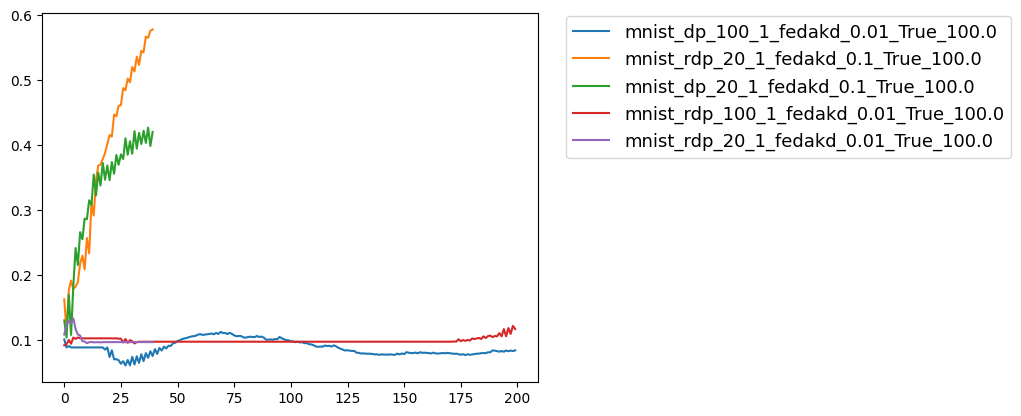

In [78]:
experiment_paths = [join(RESULTS_PATH, exp_name) for exp_name in os.listdir(RESULTS_PATH)]
idx_to_remove = [i for i in range(len(experiment_paths)) if not os.path.isdir(experiment_paths[i])]
for i in idx_to_remove :
    experiment_paths.pop(i)

fav_exps = []
for p in experiment_paths :
    exp = Exp(p) 
    if exp.corrupt :
        continue
    if exp.args['learning_algorithm'] == 'fedakd' and exp.args['use_dp'] == True :
        fav_exps.append(exp)

expset = ExpSet(fav_exps)
expset.plot(metric = 'acc', labels = ['dataset', 'dp_type', 'rounds', 'local_epochs', 'learning_algorithm', 'lr', 'use_dp', 'dp_epsilon'])
    


# DP relaxations noise vs epsilon

In [2]:
n = 60_000 
bs = 200
e = 20 
delta = 1e-5
dp_types = ['dp', 'adv_cmp', 'rdp'] 

epsilons_range = np.arange(1, 1000, 5)

noise_multipliers = np.zeros((len(dp_types), len(epsilons_range)))
for dp_i, dp_type in enumerate(dp_types) : 
    for eps_i, eps in enumerate(epsilons_range) : 
        ac = DPAccountant(
            data_size= n,
            batch_size= bs, 
            epochs = e,
            target_delta = delta, 
            dp_type = dp_type
        )
        sigma = ac.get_noise_multiplier(target_epsilon=eps)
        noise_multipliers[dp_i, eps_i] = sigma



DP-SGD with sampling rate = 0.333% and noise_multiplier = 20 iterated over 6000 steps satisfies differential privacy with eps = 0.0409 and delta = 1e-05.
The optimal RDP order is 256.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 10.0 iterated over 6000 steps satisfies differential privacy with eps = 0.0877 and delta = 1e-05.
The optimal RDP order is 128.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 5.0 iterated over 6000 steps satisfies differential privacy with eps = 0.189 and delta = 1e-05.
The optimal RDP order is 63.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 2.5 iterated over 6000 steps satisfies differential privacy with eps = 0.411 and delta = 1e-05.
The optimal RDP order is 37.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 1.25 iterated over 6000 steps satisfies differential privacy with eps = 1.03 and delta = 1e-05.
The optimal RDP order is 16.0.
DP-SGD with sampling rate = 0.333% and noise_multiplier = 1.875 iterate

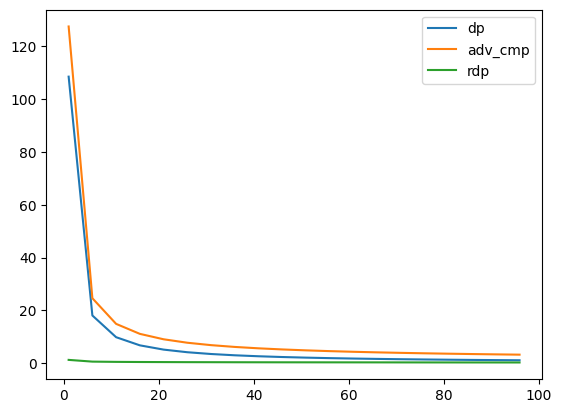

In [4]:
for dp_i, dp_type in enumerate(dp_types) : 
    plt.plot(epsilons_range[:20], noise_multipliers[dp_i, :20], label=dp_type)
plt.legend()

## MIA results

In [ ]:
id = 12
exp_id = 'exp_{}'.format(id)
EXP_PATH = join(DATA_PATH, exp_id)
attack_results_file = join(EXP_PATH, 'attack_results', 'attack_results.npy')
attack_results = np.load(attack_results_file, allow_pickle= True).item()  

fpr, tpr, thresholds = attack_results['fpr'], attack_results['tpr'], attack_results['thresholds']
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("fpr:", fpr)
print("tpr:", tpr)
print("thresholds:", thresholds)